In [ ]:
#This script is based on google colab.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

#Choose two excel files. Example, Aquarium Count 4-20-17.xlsx and Aquarium Count 4-22-17.xlsx
#These datas are from the same parking lot but different date
uploaded = files.upload()

Saving Aquarium Count 4-20-17.xlsx to Aquarium Count 4-20-17 (2).xlsx
Saving Aquarium Count 4-22-17.xlsx to Aquarium Count 4-22-17 (1).xlsx


In [3]:
files = ['/content/Aquarium Count 4-20-17 (2).xlsx', '/content/Aquarium Count 4-22-17 (1).xlsx']
dfs = []

In [7]:
for file in files:
    df = pd.read_excel(file, header=[0, 1])  # handles multi-level columns

    # Flatten multi-index columns (if multiple header rows)
    df.columns = ['_'.join([str(level) for level in col if level]) for col in df.columns]

    # Detect ID and location columns
    id_col = [c for c in df.columns if 'Loc' in c and 'ID' in c][0]
    name_col = [c for c in df.columns if 'Loc' in c and 'Name' in c][0]

    # Standardize column names
    df.rename(columns={id_col: 'Loc ID', name_col: 'Loc Name'}, inplace=True)

    # Melt wide time columns into long format
    time_cols = [c for c in df.columns if '#HCP' in c or '#NHCP' in c]
    long_df = df.melt(
        id_vars=['Loc ID', 'Loc Name'],
        value_vars=time_cols,
        var_name='Time_Type',
        value_name='Count'
    )

    # Split time and parking type into separate columns
    long_df[['Time', 'Type']] = long_df['Time_Type'].str.split('_', expand=True)
    long_df.drop(columns=['Time_Type'], inplace=True)

    # Convert counts to numeric and drop missing
    long_df['Count'] = pd.to_numeric(long_df['Count'], errors='coerce')
    long_df.dropna(subset=['Count'], inplace=True)

    # Add date information
    long_df['Date'] = file.split('-')[-1].replace('.xlsx', '')
    dfs.append(long_df)

In [8]:
# Combine both days into one dataframe
data = pd.concat(dfs, ignore_index=True)

# Compute max, min, average, and identify peak and least occupancy per lot and type
summary = (data.groupby(['Loc Name', 'Type'])
            .agg(Max_Count=('Count', 'max'),
                 Min_Count=('Count', 'min'),
                 Avg_Count=('Count', 'mean'))
            .reset_index())

# Peak hour (time of maximum)
peak_time = (data.groupby(['Loc Name', 'Type'])
             .apply(lambda x: x.loc[x['Count'].idxmax(), ['Time', 'Count']])
             .reset_index())
peak_time.columns = ['Loc Name', 'Type', 'Peak_Time', 'Peak_Count']

# Minimum hour (time of minimum)
min_time = (data.groupby(['Loc Name', 'Type'])
            .apply(lambda x: x.loc[x['Count'].idxmin(), ['Time', 'Count']])
            .reset_index())
min_time.columns = ['Loc Name', 'Type', 'Min_Time', 'Min_Count']

# Merge summaries for a final summary table
final_summary = (summary
                 .merge(peak_time, on=['Loc Name', 'Type'])
                 .merge(min_time, on=['Loc Name', 'Type']))

print("\nSummary of Parking Lots:")
print(final_summary.head())


Summary of Parking Lots:
               Loc Name   Type  Max_Count  Min_Count_x  Avg_Count Peak_Time  \
0   175 E.3rd st Condos   #HCP          0            0     0.0000   7AM-9AM   
1   175 E.3rd st Condos  #NHCP          0            0     0.0000   7AM-9AM   
2  200 Cherry St Condos   #HCP          0            0     0.0000   7AM-9AM   
3  200 Cherry St Condos  #NHCP          5            3     3.9375   1PM-3PM   
4    212 Market St. Lot   #HCP          0            0     0.0000   7AM-9AM   

   Peak_Count Min_Time  Min_Count_y  
0           0  7AM-9AM            0  
1           0  7AM-9AM            0  
2           0  7AM-9AM            0  
3           5  1PM-3PM            3  
4           0  7AM-9AM            0  


/tmp/ipython-input-3495028774.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Count'].idxmax(), ['Time', 'Count']])
/tmp/ipython-input-3495028774.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['Count'].idxmin(), ['Time', 'Count']])


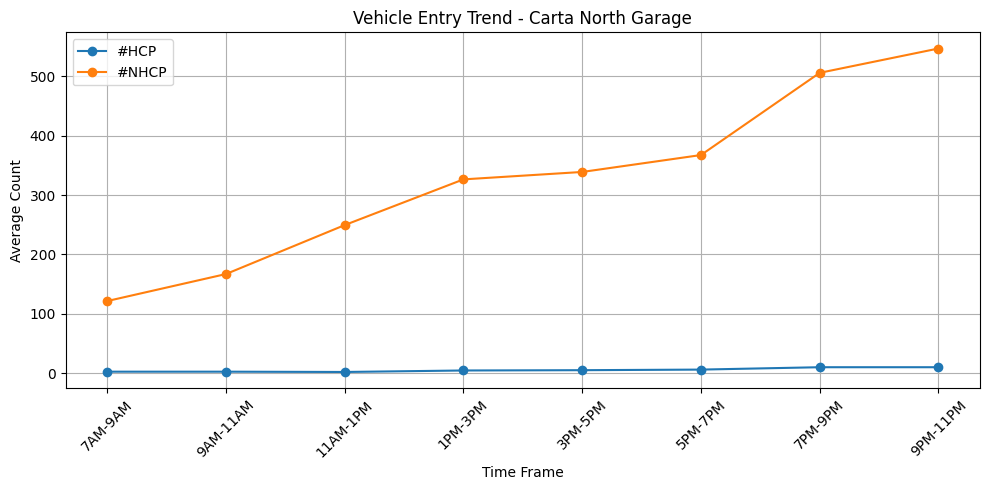

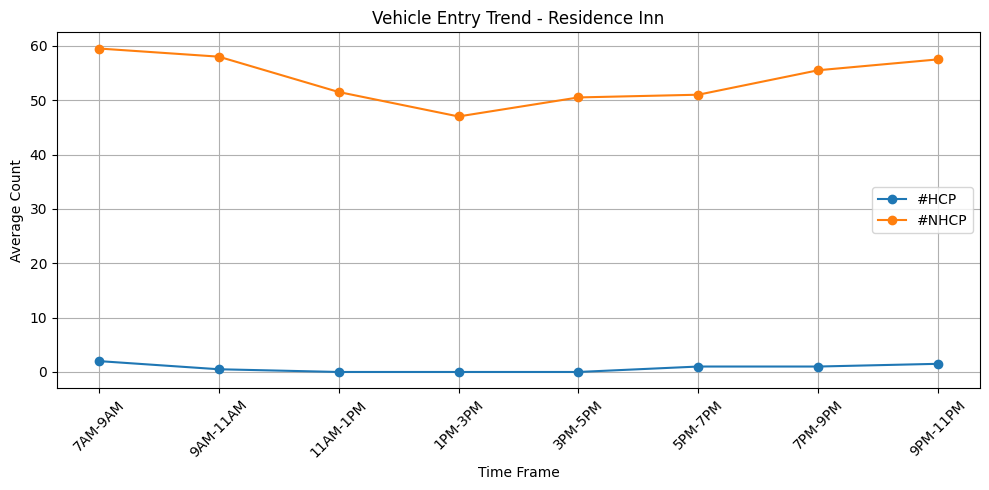

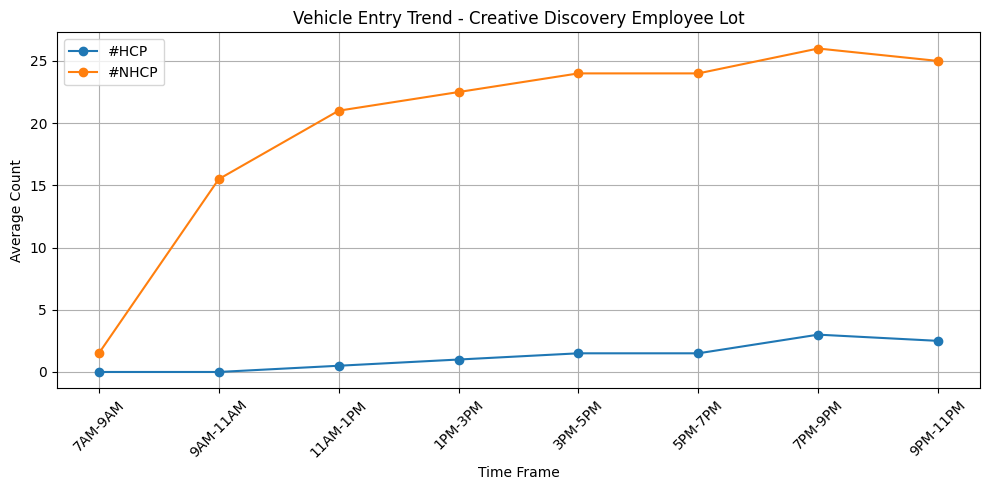

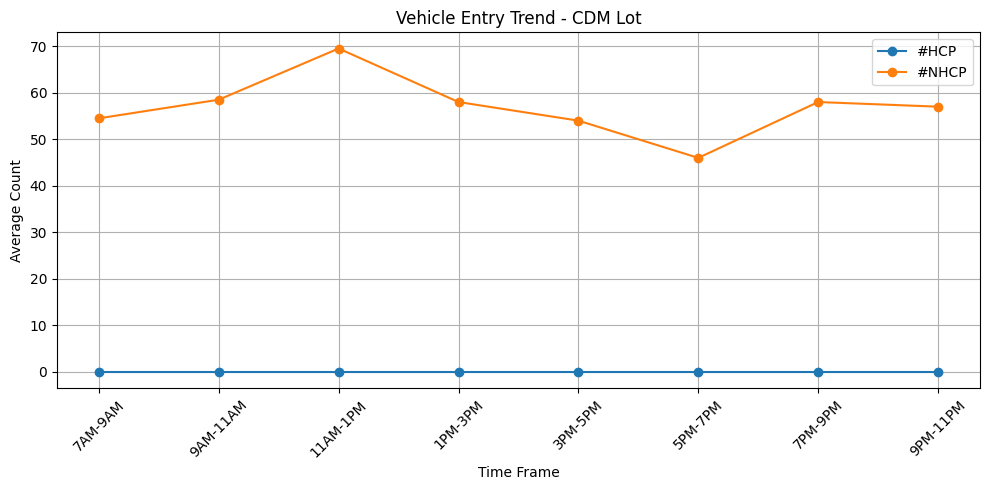

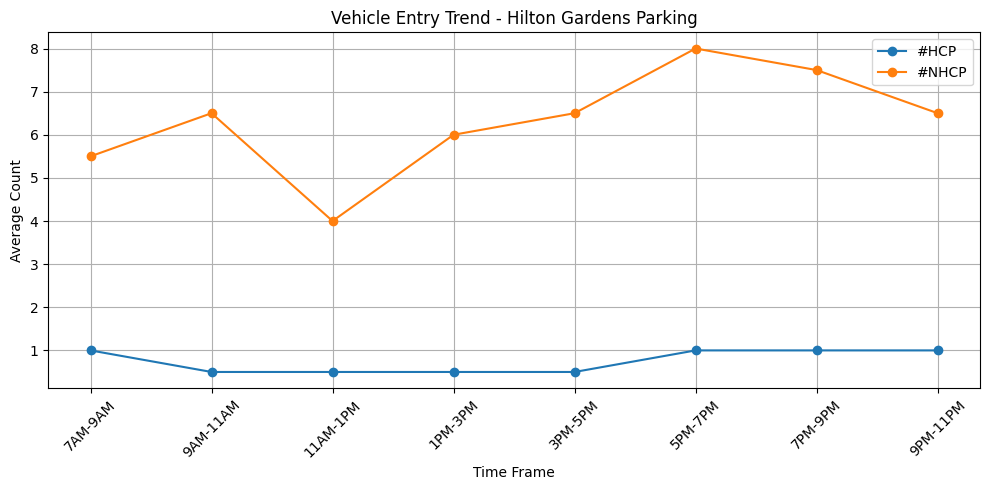

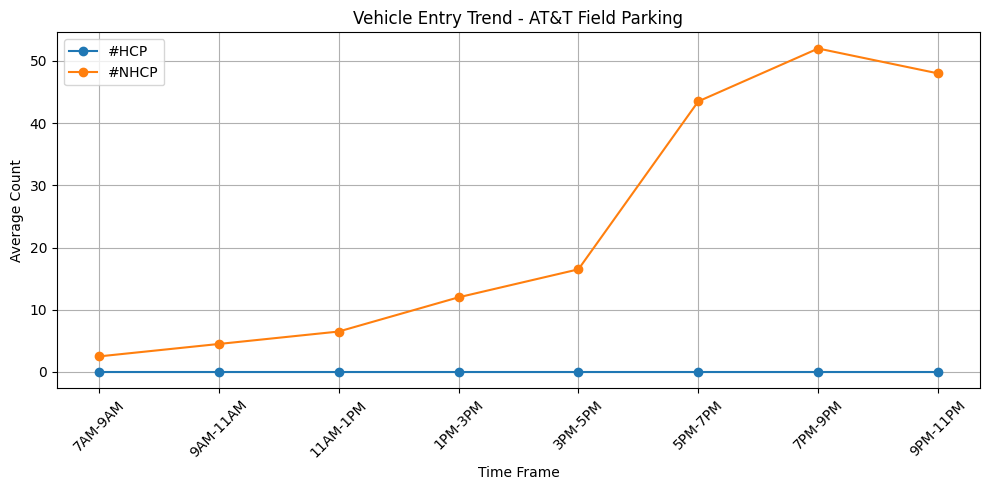

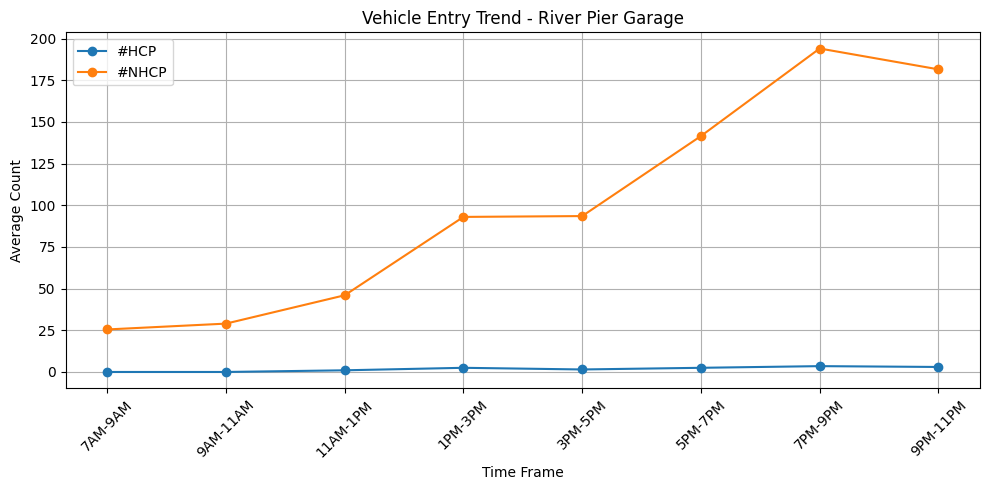

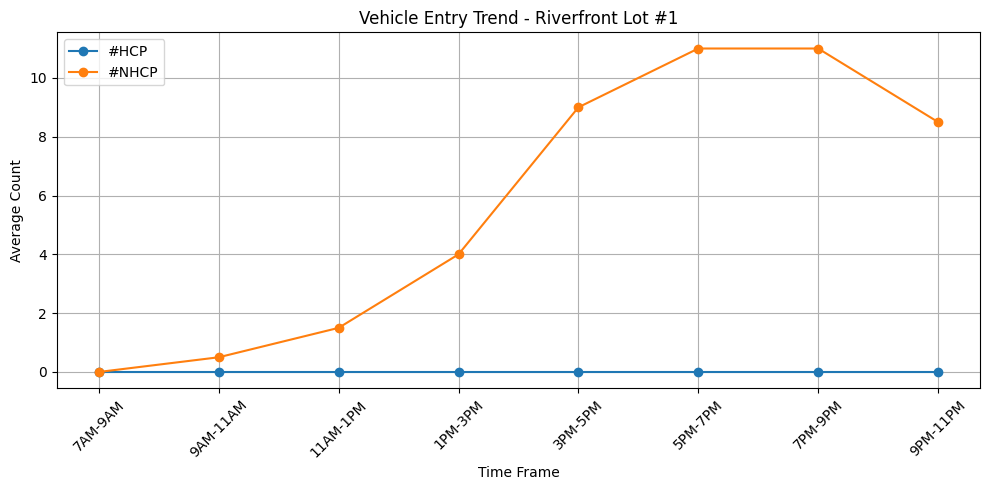

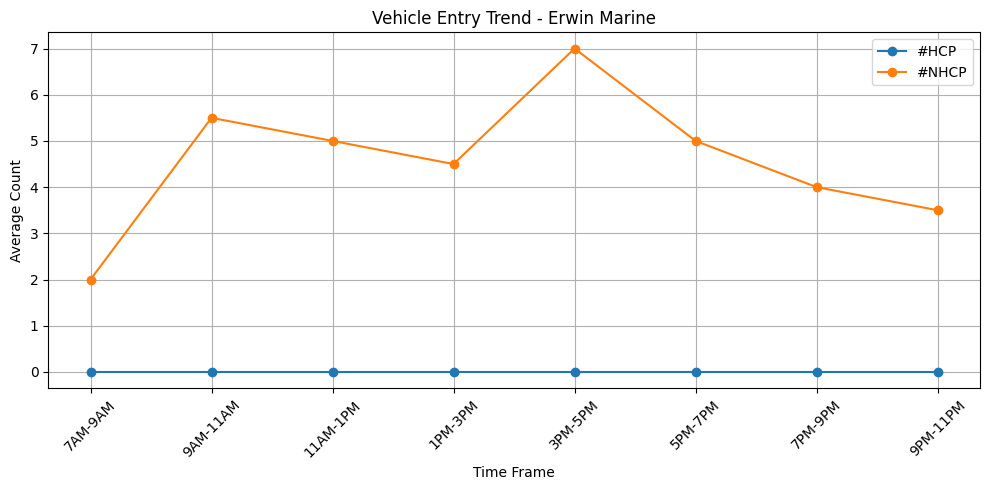

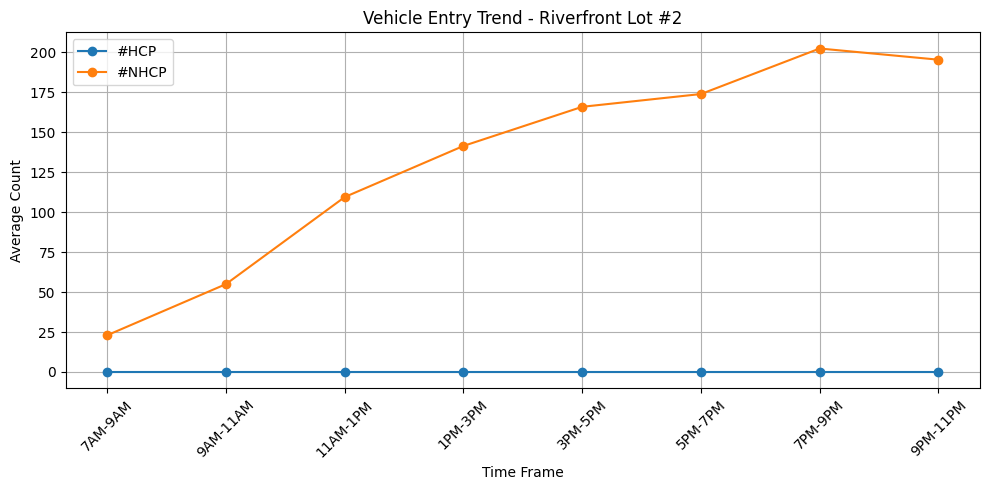

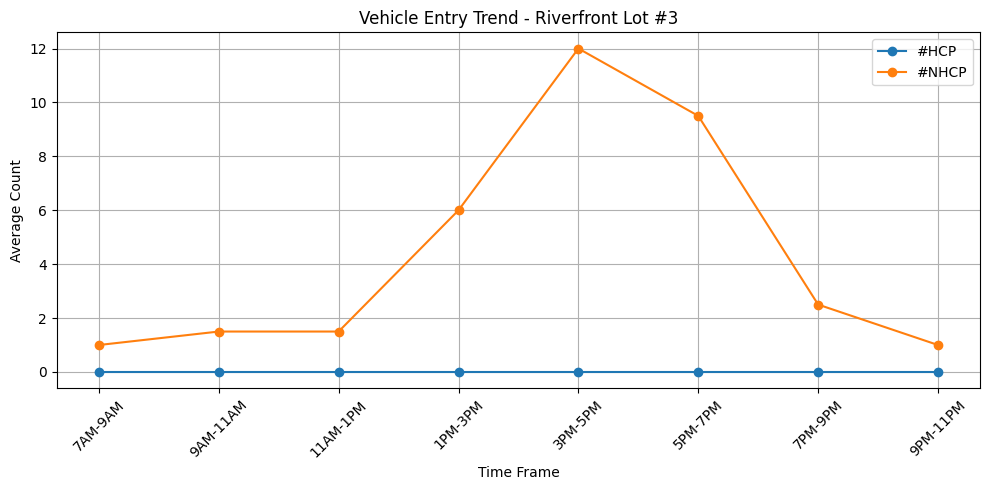

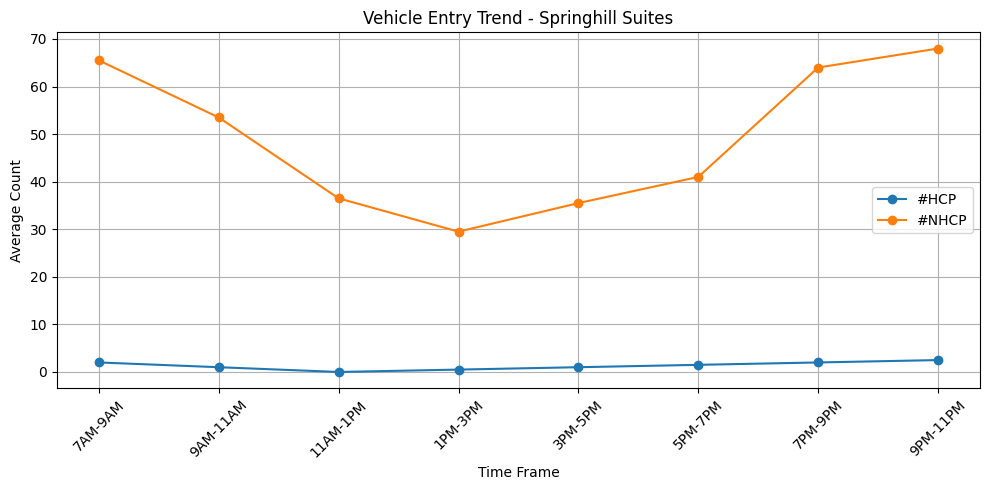

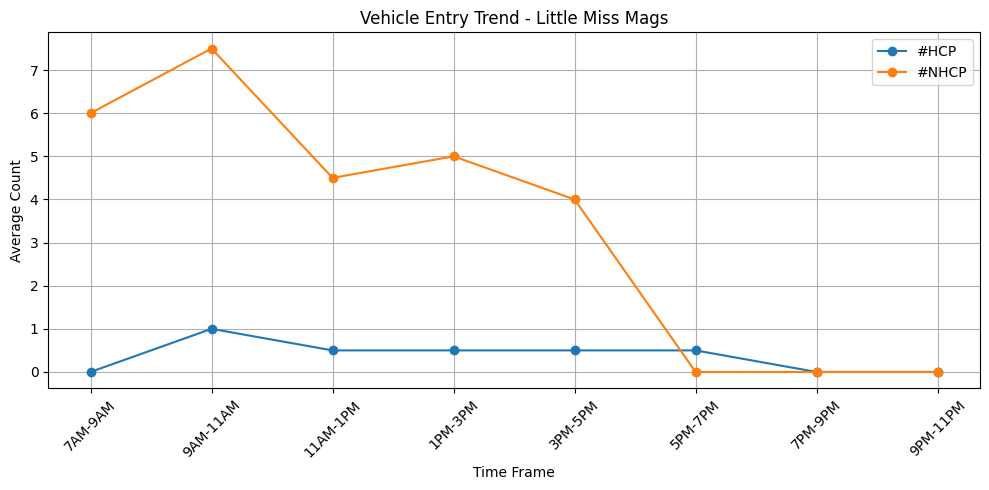

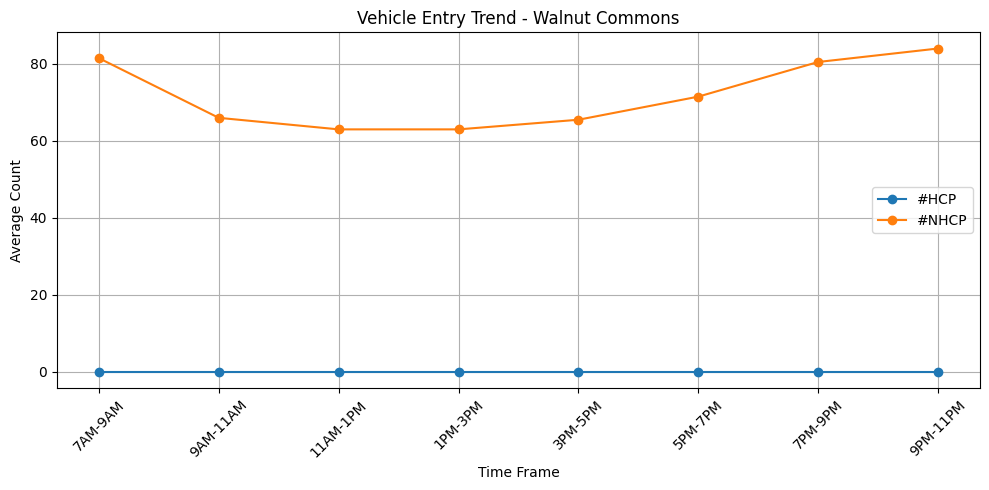

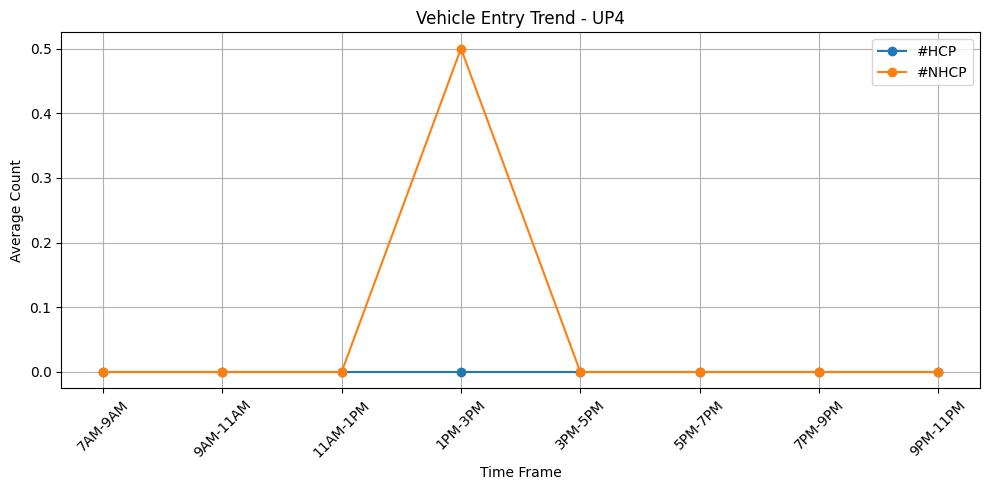

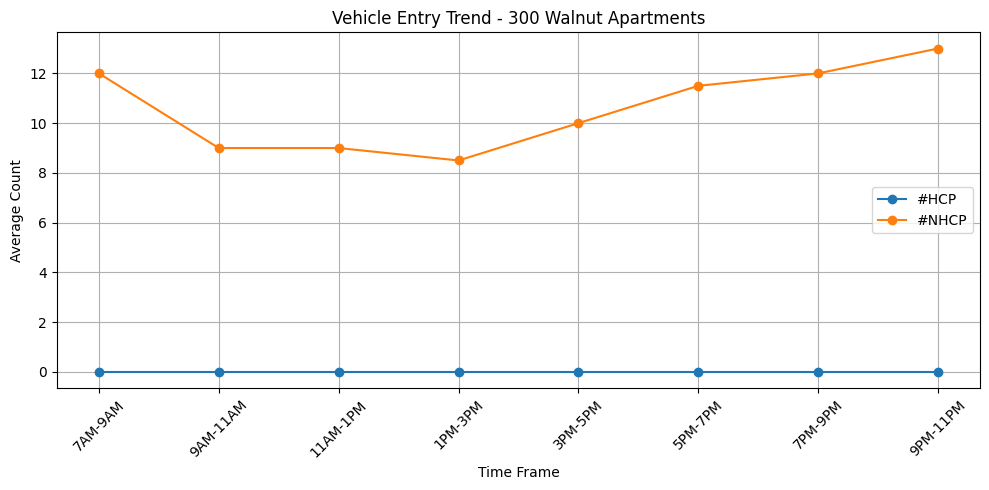

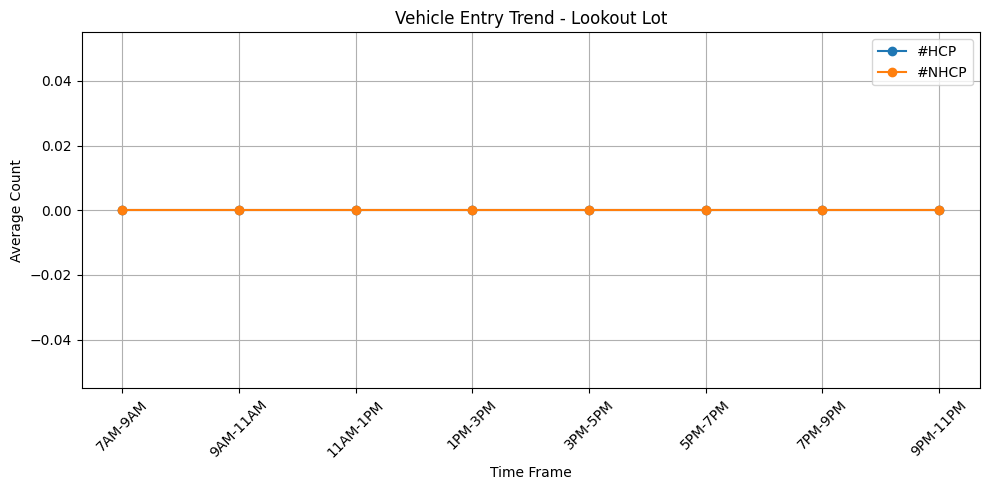

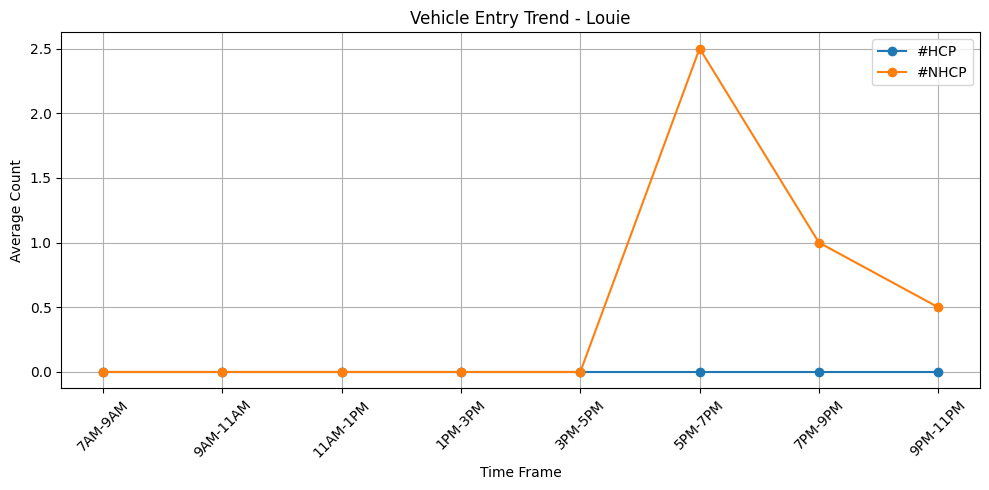

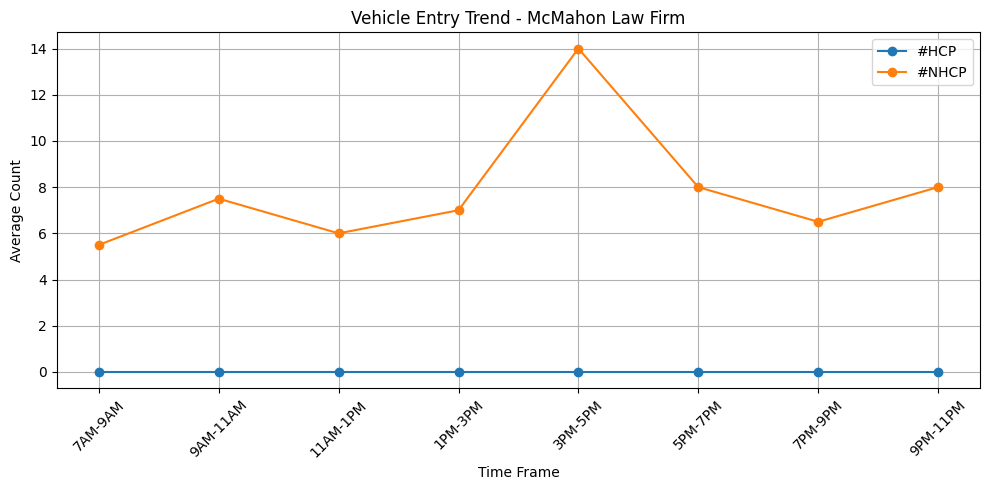

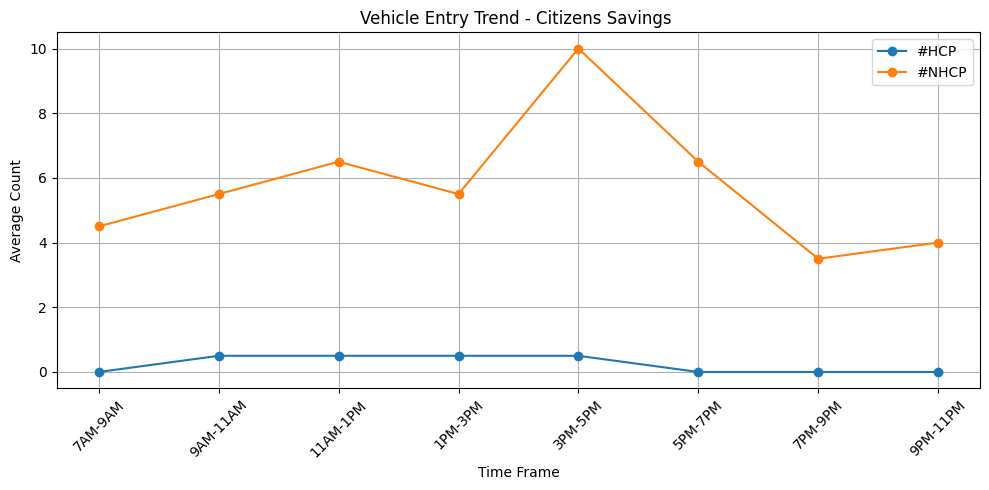

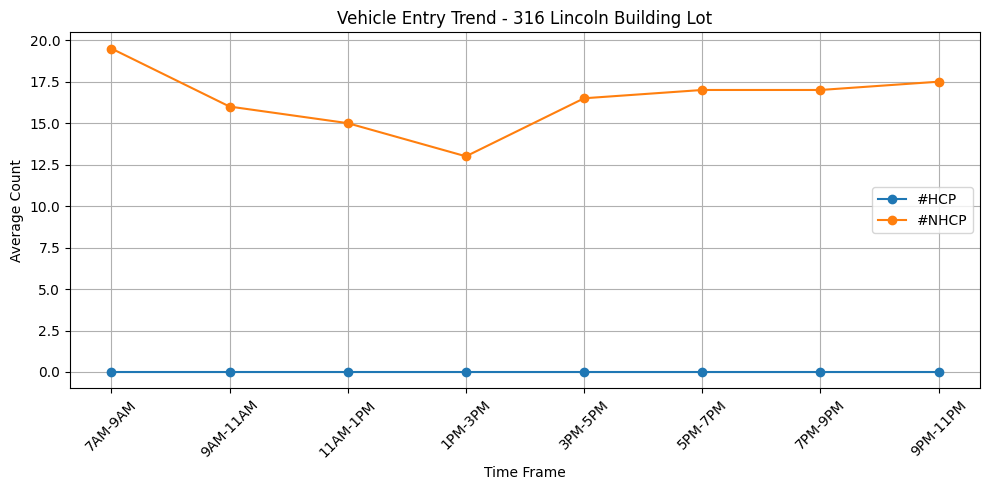

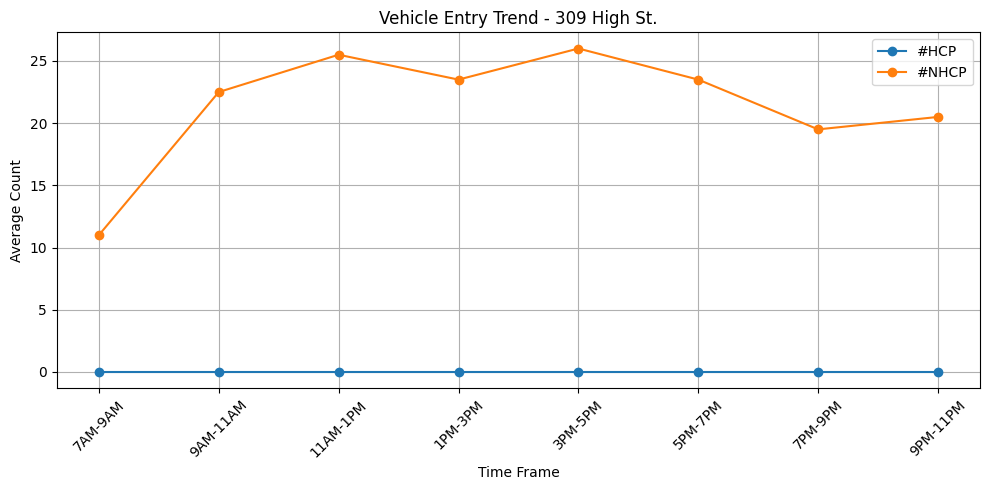

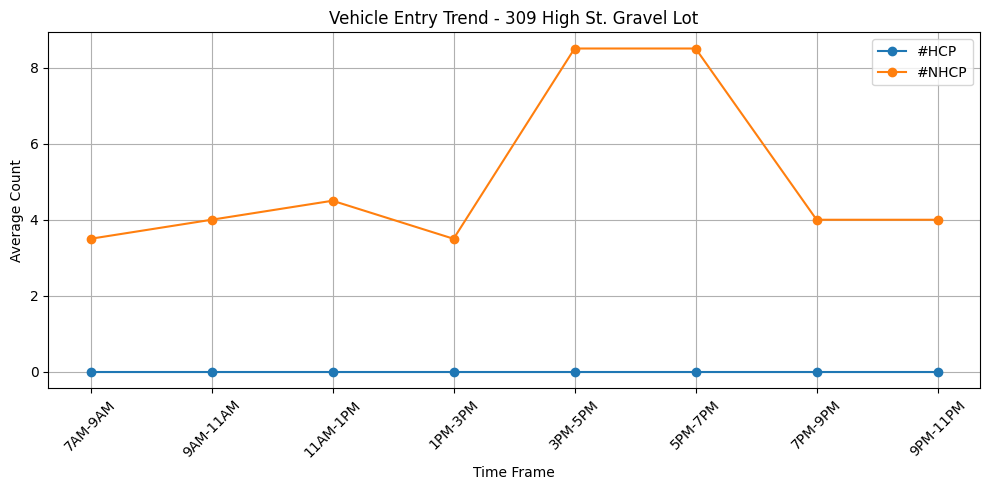

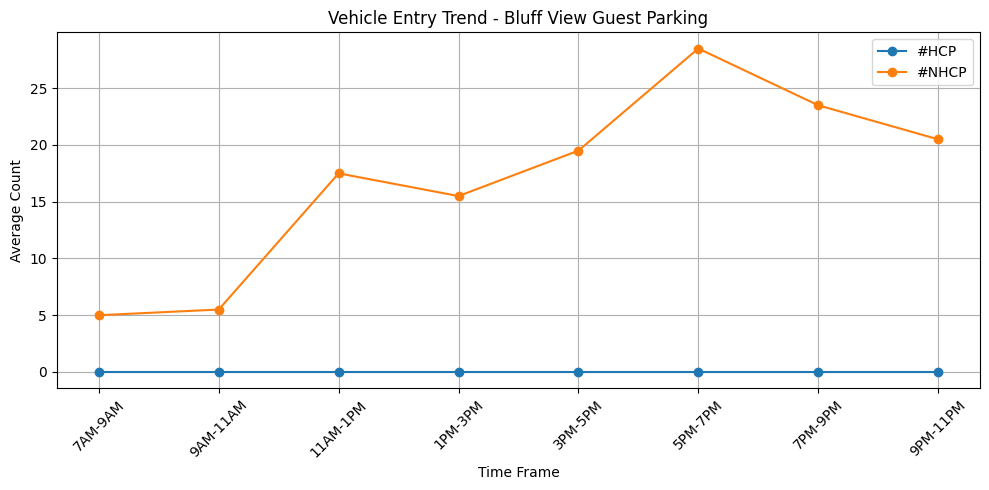

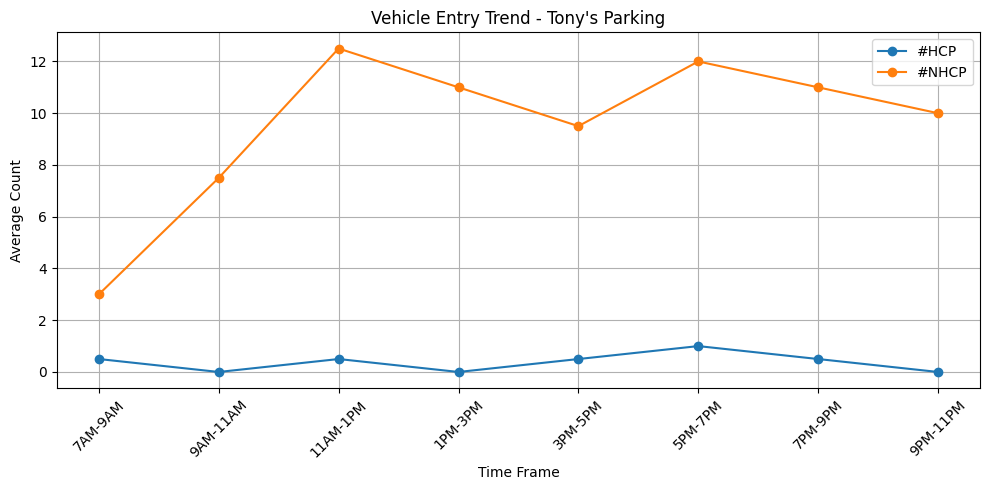

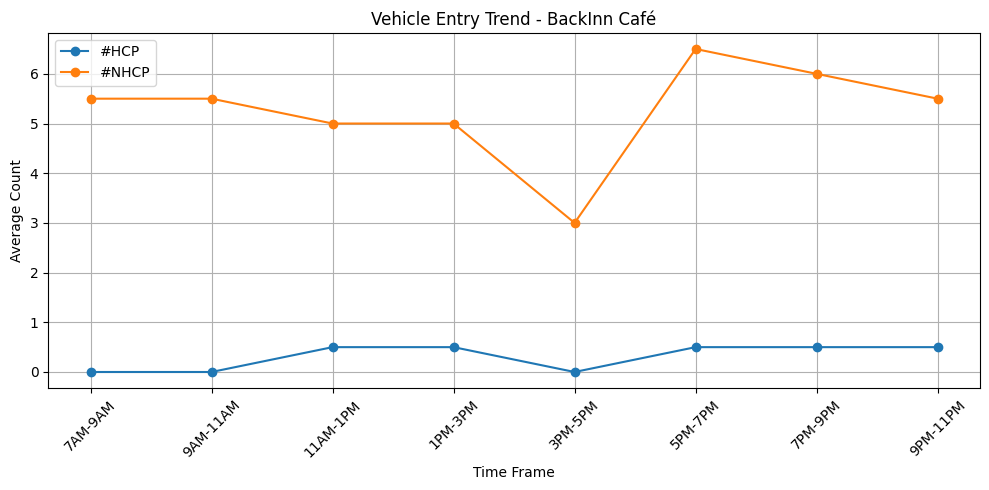

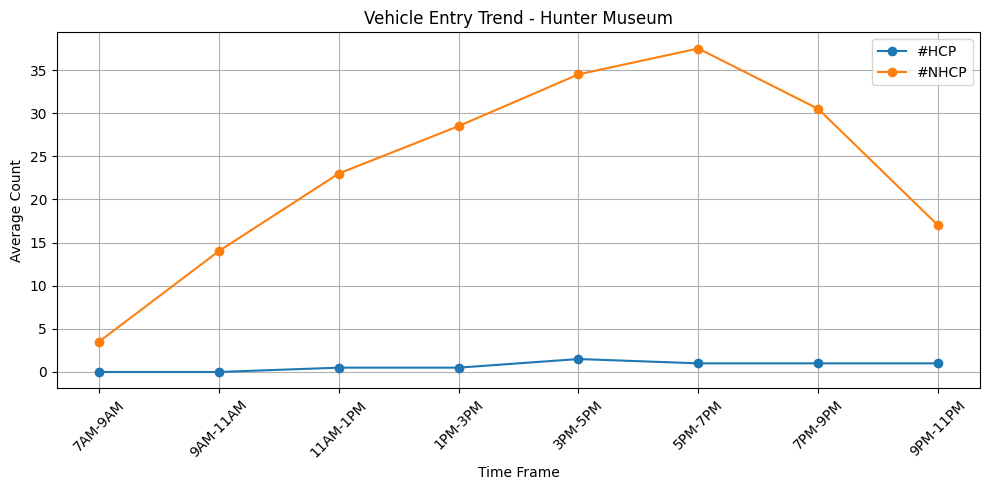

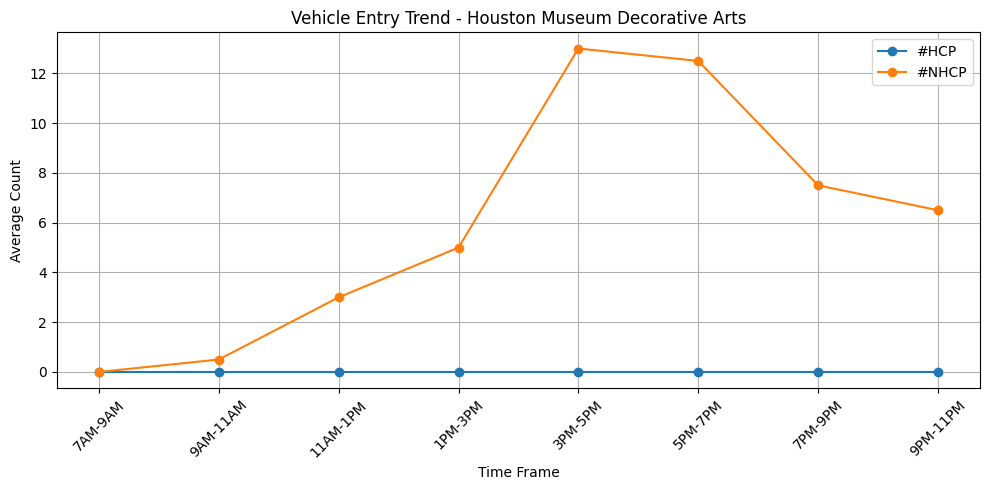

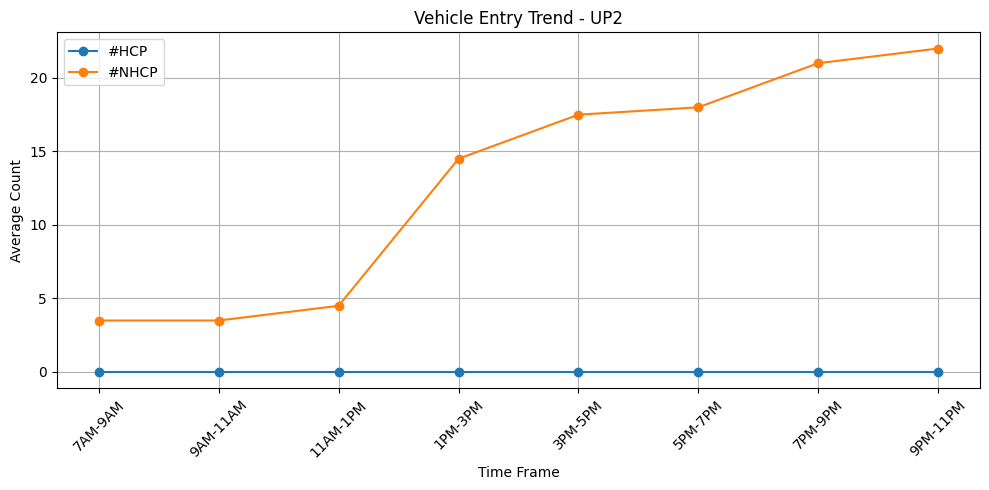

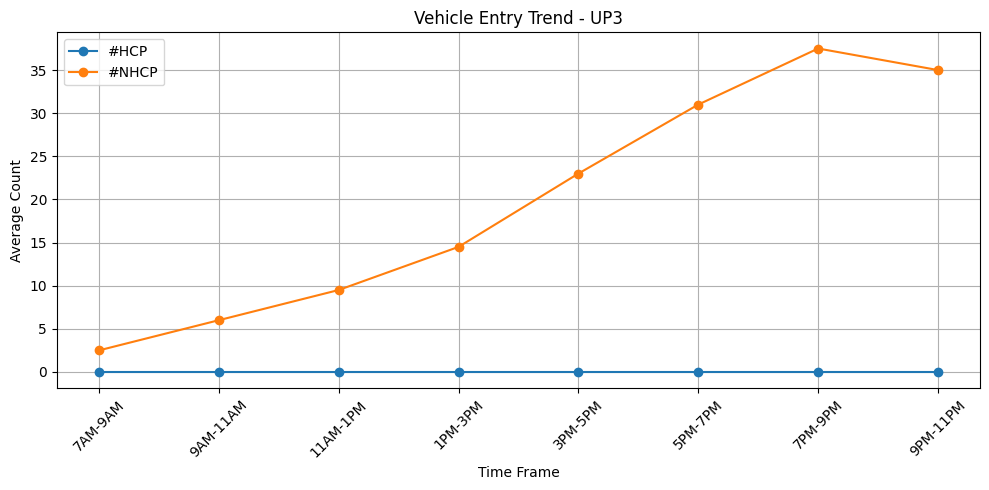

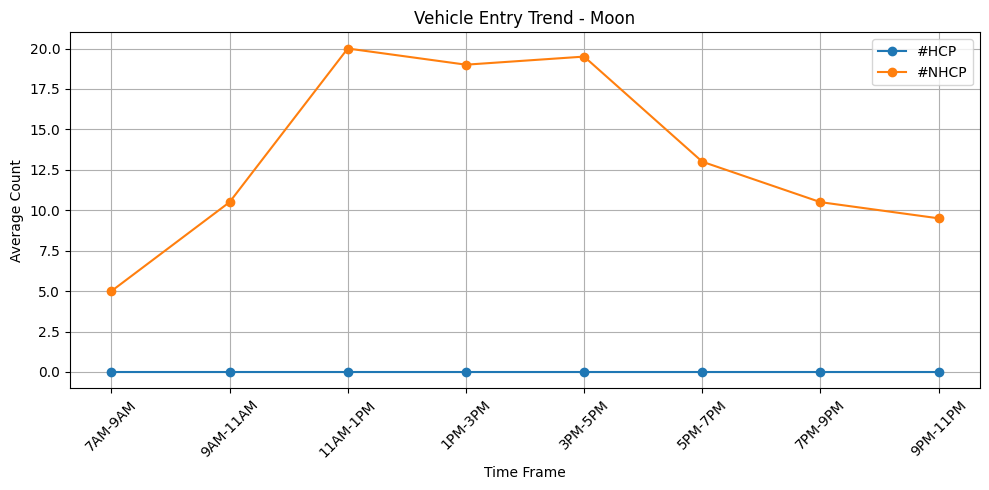

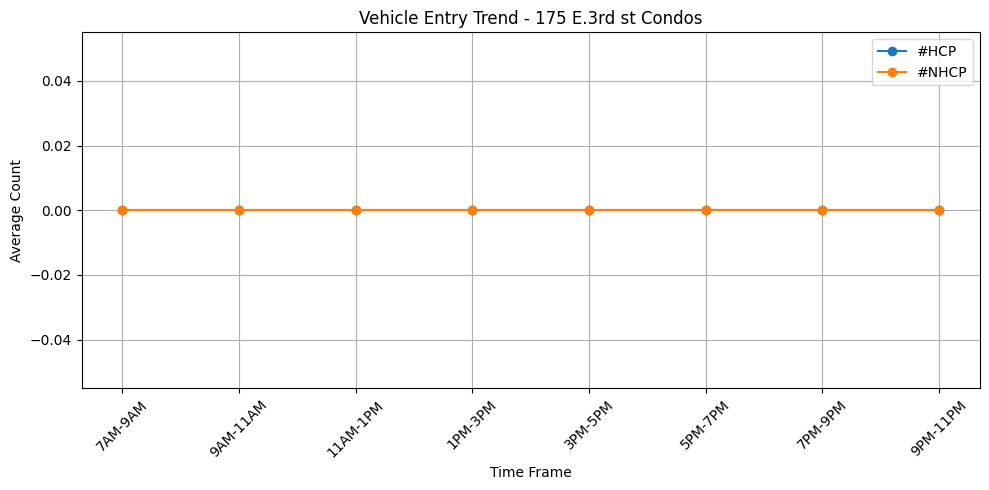

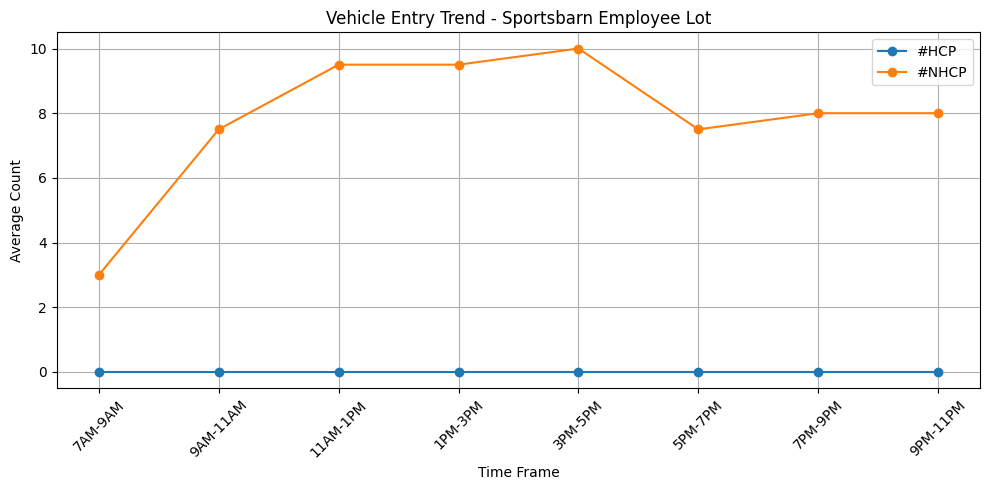

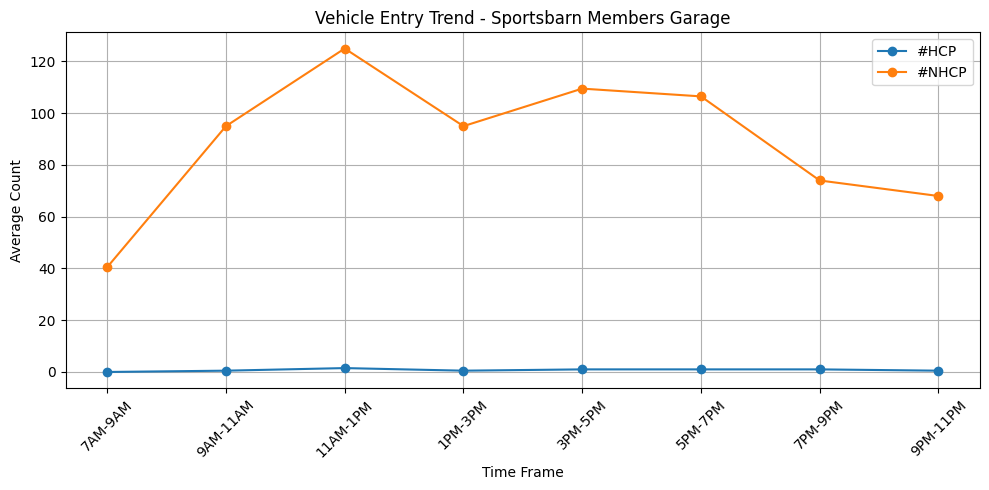

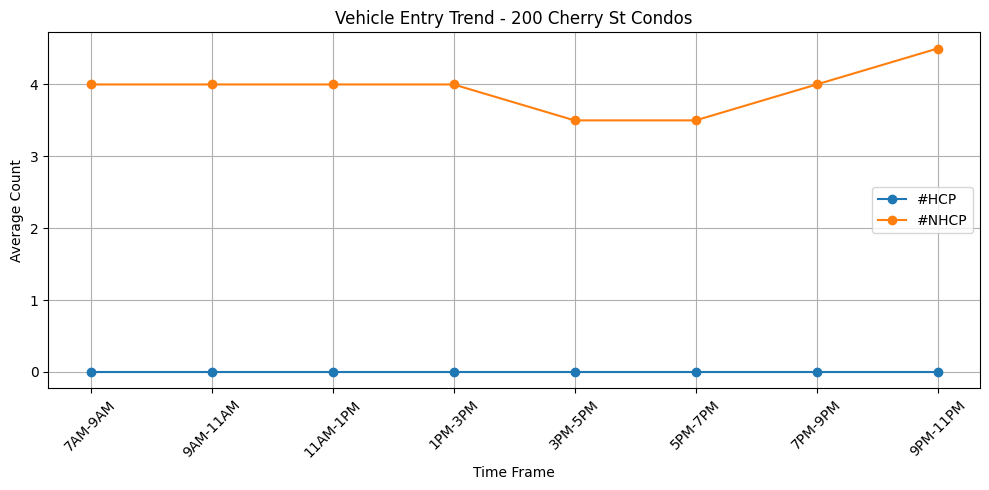

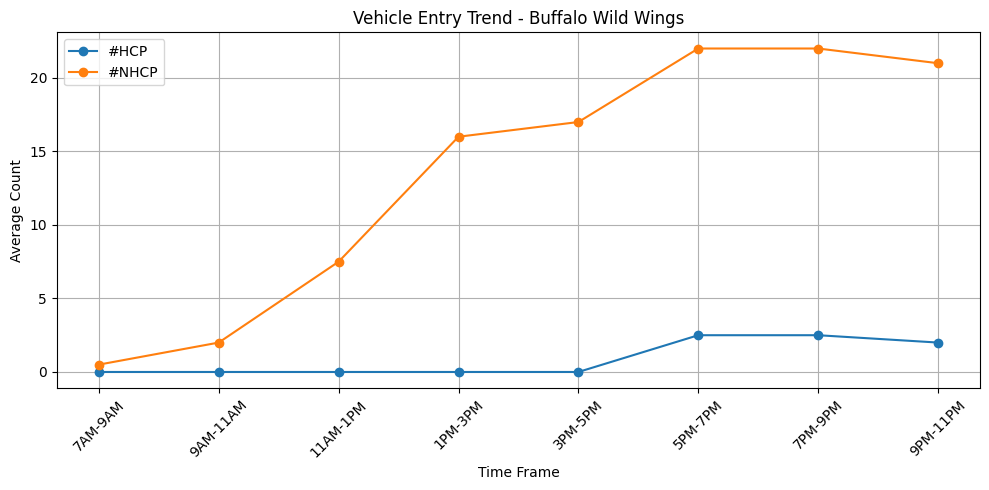

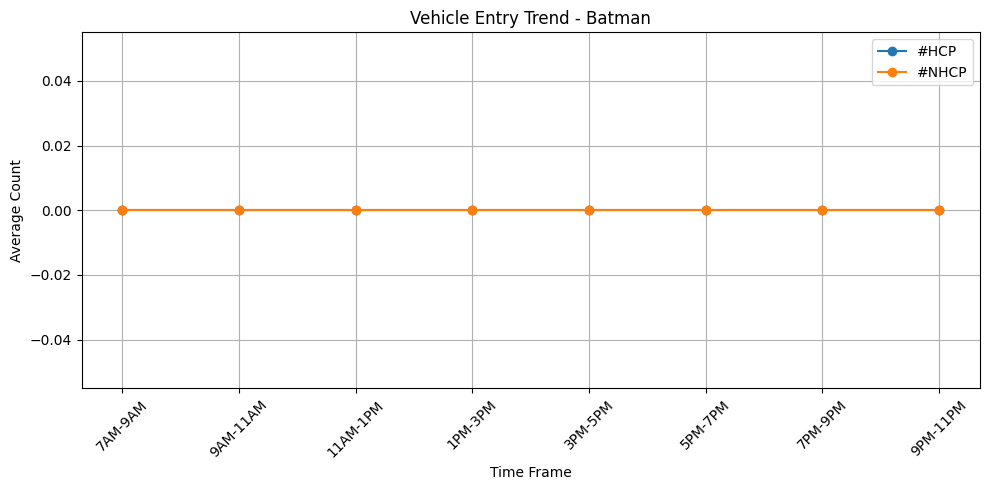

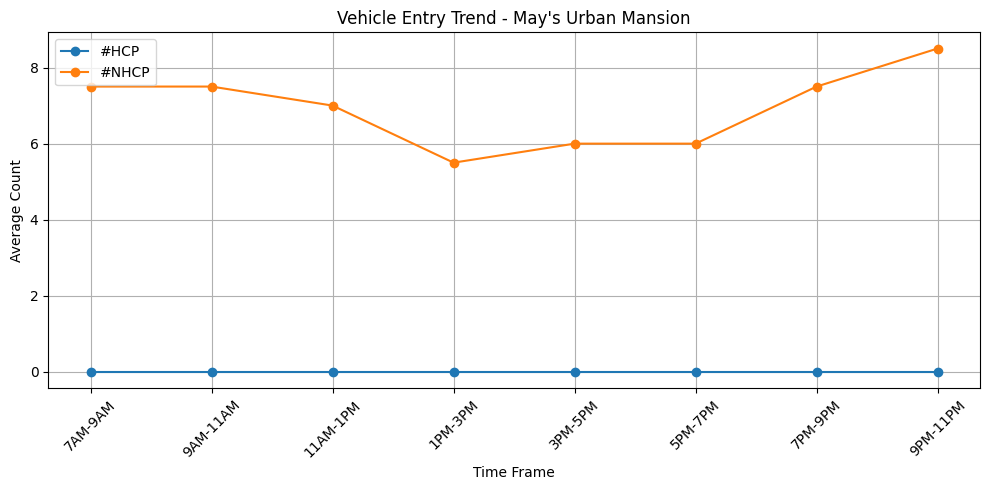

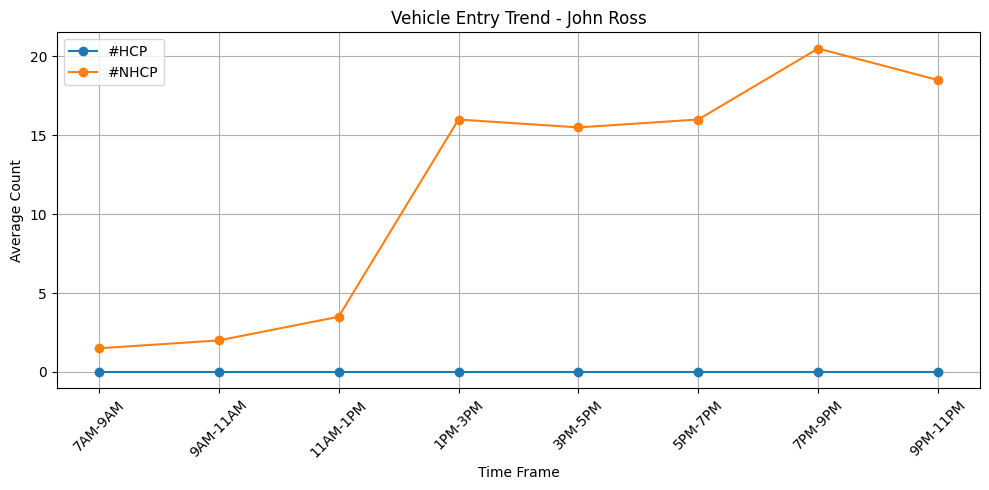

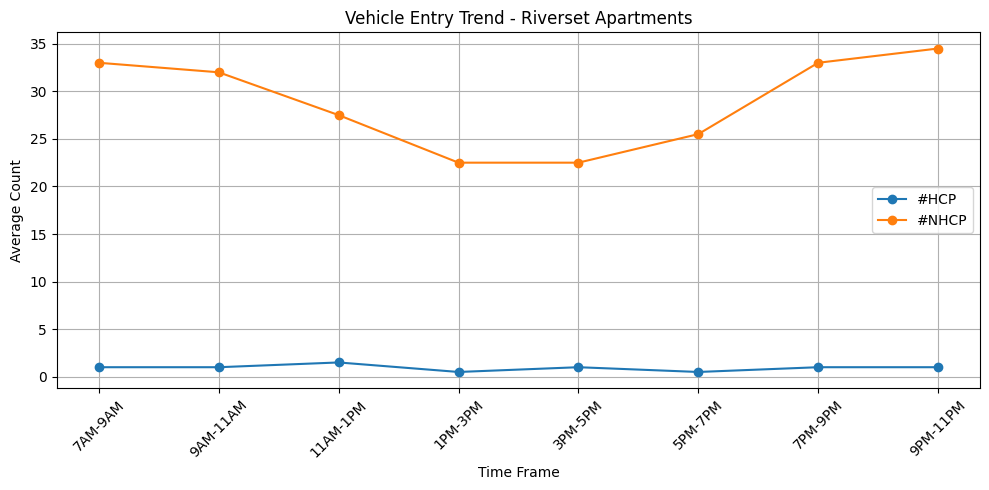

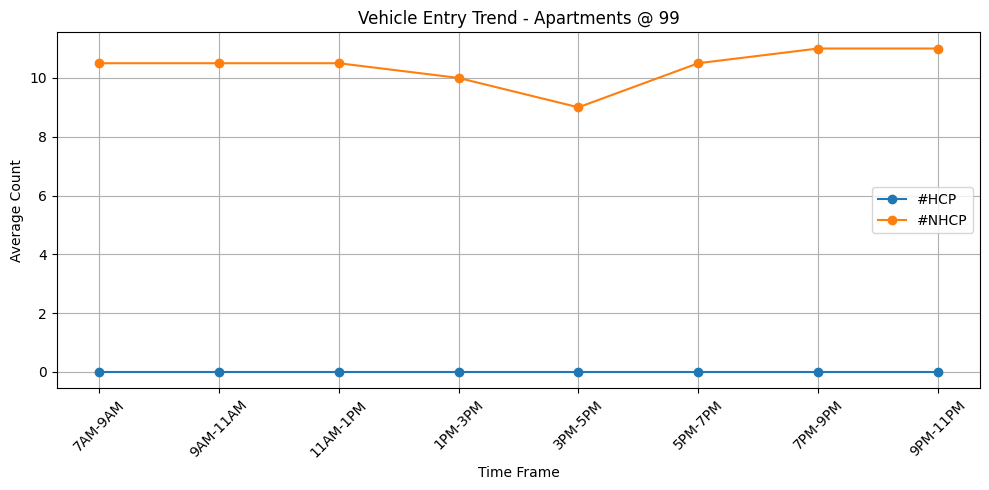

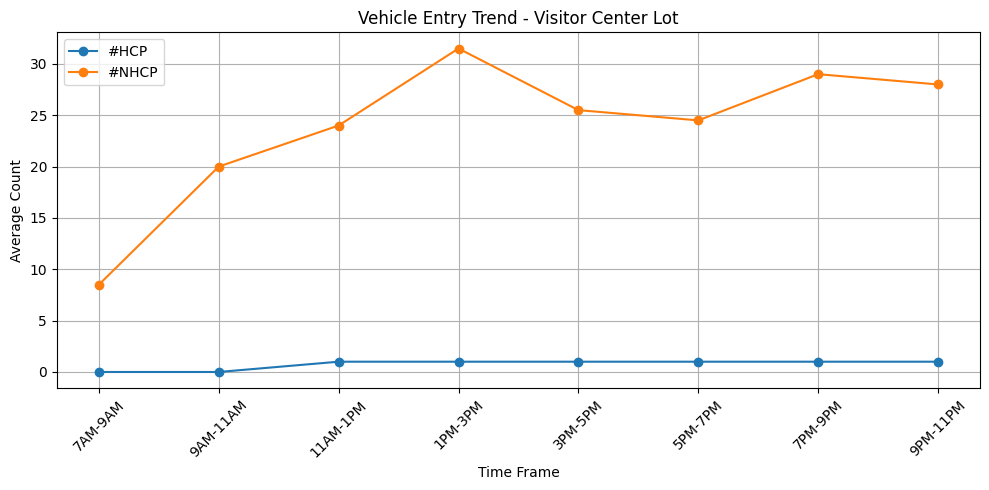

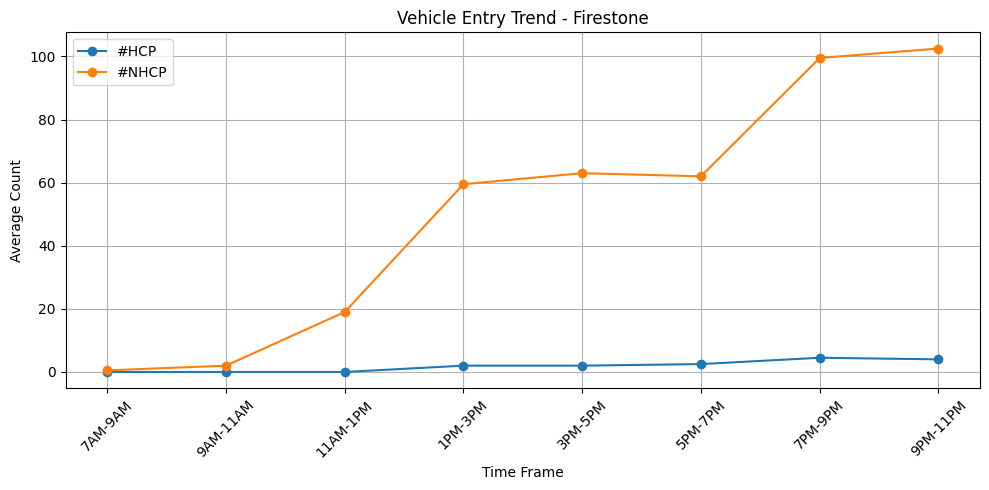

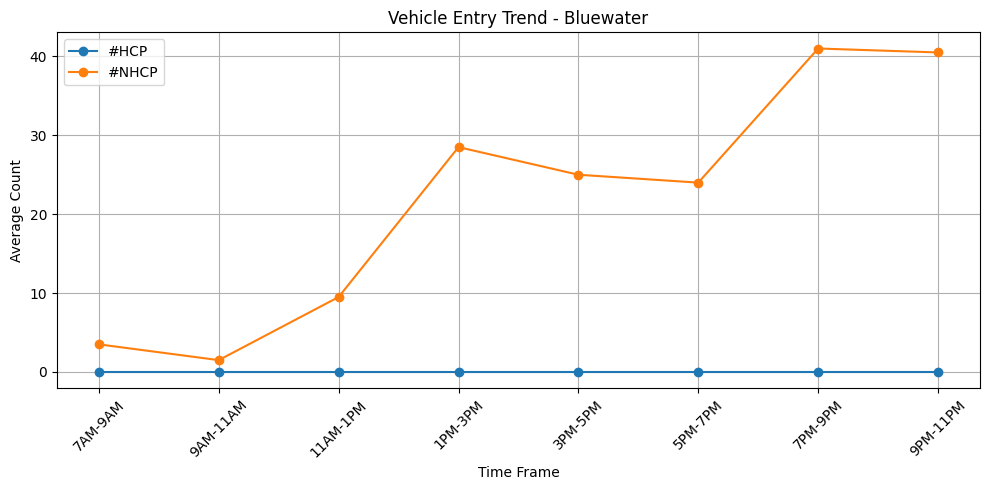

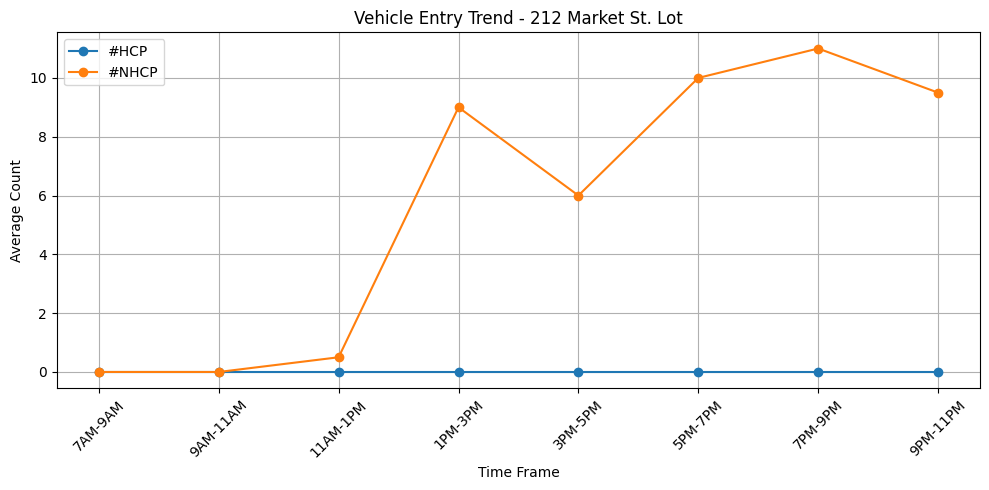

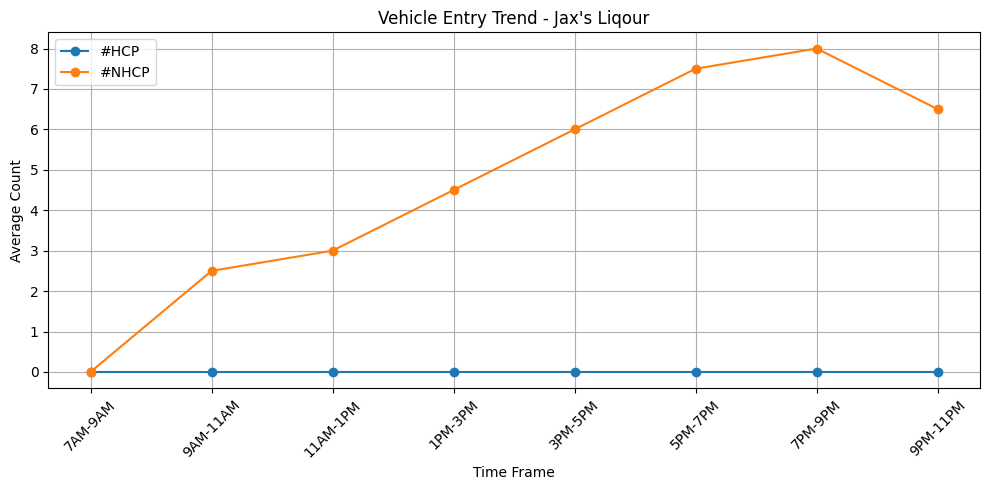

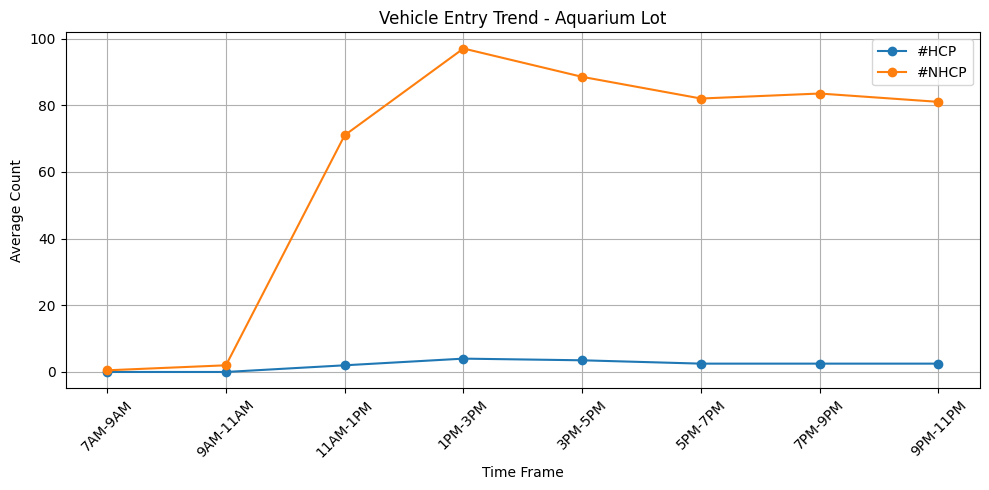

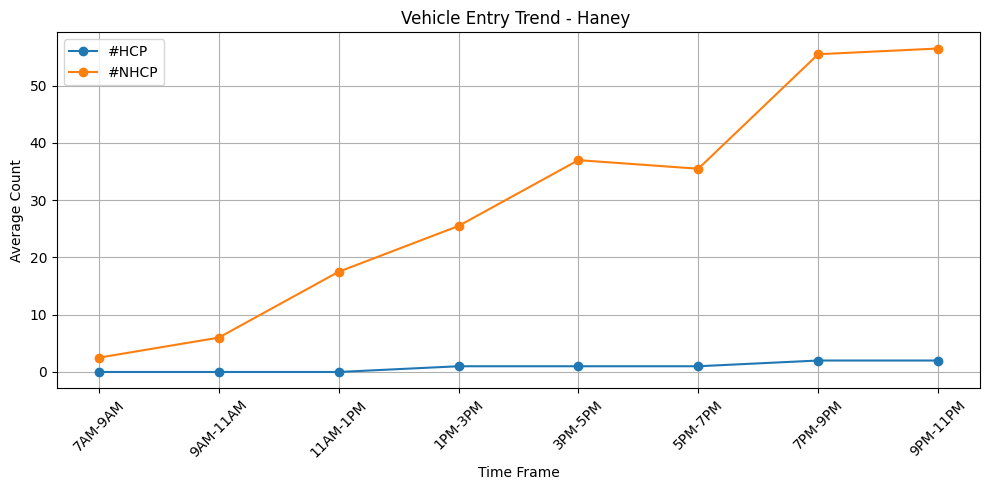

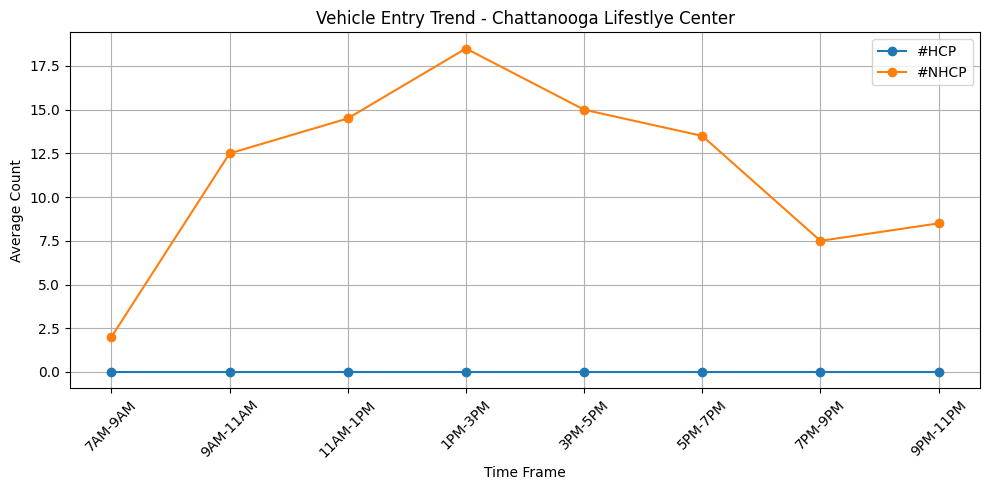

In [9]:
# --- Visualization ---
# Plot occupancy trends for each location
import re

def timekey(time_str):
    """Converts times like '7AM', '9PM' etc. to a sortable number (24-hour clock)."""
    match = re.match(r'(\d+)(AM|PM)', time_str)
    if match:
        hour = int(match.group(1))
        period = match.group(2)
        if period == 'PM' and hour != 12:
            hour += 12
        elif period == 'AM' and hour == 12:
            hour = 0
        return hour
    return 999  # fallback for sorting

# Dynamically extract, deduplicate, and sort all existing time slots
unique_times = sorted(data['Time'].dropna().unique(), key=timekey)

# Re-categorize the Time column so plots will use the detected chronological order
data['Time'] = pd.Categorical(data['Time'], categories=unique_times, ordered=True)

for loc in data['Loc Name'].unique():
    subset = data[data['Loc Name'] == loc]
    plt.figure(figsize=(10, 5))
    for t in subset['Type'].unique():
        sub_type = subset[subset['Type'] == t]
        avg_trend = (sub_type.groupby('Time', observed=True)['Count'].mean().reset_index())
        avg_trend = avg_trend.sort_values('Time')
        plt.plot(avg_trend['Time'], avg_trend['Count'], marker='o', label=t)
    plt.title(f"Vehicle Entry Trend - {loc}")
    plt.xlabel('Time Frame')
    plt.ylabel('Average Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
